In [1]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import networkx as nx
import scipy.signal as sp
import random
import pickle
import tensorflow as tf
from tensorflow import keras

In [21]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = .01
q = .5
num_inputs = 1
 
weight_matrix = tf.Variable(q * np.identity(num_nodes))
connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i,i] = 0
    connectivity_matrix[i,i] = 0
weight_matrix = tf.Variable(weight_matrix)
connectivity_matrix = tf.constant(connectivity_matrix)
noise_weights = 0 * np.ones(num_nodes)
bias_weights = 0 * np.ones(num_nodes)
input_weights = np.random.normal(0, 1/np.sqrt(num_inputs), num_nodes)

#input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)).T)
input_weight_matrix = tf.constant(np.random.normal(0, 1/np.sqrt(num_inputs), (num_nodes, 1)))

def rule_input(time):
    #running for 5 seconds = 5000ms, input switches between 1 and 0 every second
    if time//1000 % 2 == 0:
        return .2
    else:
        return .8
def target_func(time):
    #running for 5 seconds = 5000ms, input switches between .2 and .8 every second.
    if time//1000 % 2 == 0:
        return .8
    else:
        return .2
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [rule_input]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(np.random.uniform(0, 1/np.sqrt(num_nodes), (1, num_nodes)))
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 735.96it/s]


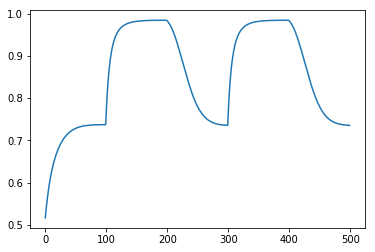

In [22]:
time = 5000 #ms
outputs, activations = network.simulate(time, input_funcs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
#plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [23]:
num_iters = 500
time = 5000 #ms
#regularizer = tf.keras.regularizers.L1(l1 = 0.0001)
weight_history = network.train(num_iters, [target_func], time, num_trials = 1, input_funcs = input_funcs,
              input_weight_matrix = input_weight_matrix, learning_rate = .001)#, regularizer = regularizer)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

The loss is: tf.Tensor(0.22917518, shape=(), dtype=float32) at iteration 0


 10%|████████                                                                         | 50/500 [01:15<14:12,  1.89s/it]

The loss is: tf.Tensor(0.11233489, shape=(), dtype=float32) at iteration 50


 20%|████████████████                                                                | 100/500 [02:22<08:40,  1.30s/it]

The loss is: tf.Tensor(0.090934075, shape=(), dtype=float32) at iteration 100


 30%|████████████████████████                                                        | 150/500 [03:28<07:25,  1.27s/it]

The loss is: tf.Tensor(0.07034, shape=(), dtype=float32) at iteration 150


 40%|████████████████████████████████                                                | 200/500 [04:37<06:54,  1.38s/it]

The loss is: tf.Tensor(0.06542837, shape=(), dtype=float32) at iteration 200


 50%|████████████████████████████████████████                                        | 250/500 [05:49<05:59,  1.44s/it]

The loss is: tf.Tensor(0.061563827, shape=(), dtype=float32) at iteration 250


 60%|████████████████████████████████████████████████                                | 300/500 [06:58<04:24,  1.32s/it]

The loss is: tf.Tensor(0.060172282, shape=(), dtype=float32) at iteration 300


 70%|████████████████████████████████████████████████████████                        | 350/500 [08:14<03:23,  1.36s/it]

The loss is: tf.Tensor(0.056877542, shape=(), dtype=float32) at iteration 350


 80%|████████████████████████████████████████████████████████████████                | 400/500 [09:23<02:25,  1.45s/it]

The loss is: tf.Tensor(0.05365209, shape=(), dtype=float32) at iteration 400


 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [10:51<01:40,  2.01s/it]

The loss is: tf.Tensor(0.05207248, shape=(), dtype=float32) at iteration 450


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [12:01<00:00,  1.38s/it]


In [24]:
network.reset_activations()
outputs, activations = network.simulate(time, input_funcs, input_weight_matrix)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 797.44it/s]


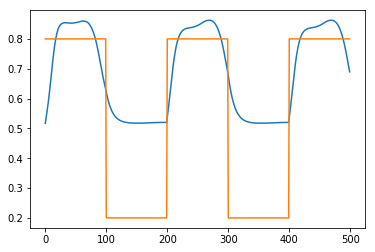

In [25]:

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [26]:
outputs = np.asarray(outputs)

targets = np.asarray([target_func(t * timestep) for t in range(len(outputs))])
print(timestep)
print(time)
np.mean((outputs - targets)**2)

10
5000


0.0482081596134772

In [16]:
network.l2_loss_func([target_func], time, num_trials = 1, regularizer = None,
                     input_funcs = input_funcs, input_weight_matrix = input_weight_matrix, error_mask = 1)


<tf.Tensor: shape=(), dtype=float32, numpy=0.071047656>

TypeError: list indices must be integers or slices, not tuple

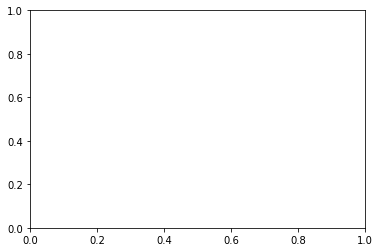

In [17]:
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()